In [33]:
import os
import tensorflow as tf
from keras import models
from keras import layers
from datetime import datetime
from PIL import Image
import numpy as np
import keras.backend as K
import matplotlib.pyplot as plt
import mlflow

# Scientific data

In [34]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from keras.models import Model


In [35]:
K.clear_session()

In [36]:
batch_size = 64

In [37]:
mlflow.set_experiment('efficientnet_project')
mlflow.autolog()

2023/03/13 10:37:09 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


In [ ]:
#Keras.sequence


In [77]:
#Check the 3!
image_size = (255, 255)


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'combined_dataset',
    validation_split=0.2,
    subset="training",
    label_mode = 'int',
    labels = 'inferred',
    seed=1336,
    image_size=image_size,
    interpolation = 'bilinear',
    batch_size=batch_size,
    shuffle = True,
)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'combined_dataset',
    validation_split=0.2,
    subset="validation",
    label_mode = 'int',
    labels = 'inferred',
    seed=1336,
    image_size=image_size,
    interpolation = 'bilinear',
    batch_size=batch_size,
    shuffle = True,
)


Found 16752 files belonging to 3 classes.
Using 13402 files for training.
Found 16752 files belonging to 3 classes.
Using 13401 files for validation.


In [39]:
imput = (255,255,3)

In [64]:
base_model = EfficientNetB3(include_top = False ,weights='imagenet', pooling='avg')

#Meter data augmentation


# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last 20 layers in the base model for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

#Capa de entradas. No se si eficientnet ya espera 225x225 o es 224 x 224. En realidad la efficient net ya tiene un parametro de input shape...
entradas = layers.Input((255,255,3))

x = base_model(entradas)

#No es necesario escalar las imagenes porque eficientnet ya tiene una capa de escalado
# x = layers.Rescaling(scale = 1./255, offset=0.0)(x)

# Add a dense layer
x = layers.Dense(512, activation='relu')(x)
# Add another dense layer
salidas = layers.Dense(3, activation='softmax')(x)

modelo = Model(inputs = entradas, outputs = salidas)

modelo.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
modelo.summary()




Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 255, 255, 3)]     0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 1536)              10783535  
_________________________________________________________________
dense_4 (Dense)              (None, 512)               786944    
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 1539      
Total params: 11,572,018
Trainable params: 2,490,371
Non-trainable params: 9,081,647
_________________________________________________________________


In [65]:
# Display the model architecture in the notebook
# plot_model(modelo, to_file='model.png', show_shapes=True)


In [66]:
folder_date = 'old_models/' +  datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
os.mkdir(folder_date)
filepath_model = folder_date + '/my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'


# Callbacks

In [67]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath=filepath_model,
save_weights_only=False,
monitor='val_accuracy',
mode='max',
save_freq="epoch",
save_best_only=True)

In [68]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, mode='auto', verbose = 1, )

In [69]:
epochs = 20
history = modelo.fit(
    train_ds, epochs=epochs, validation_data=val_ds, callbacks=[model_checkpoint_callback]
)

2023/03/13 14:42:49 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2a223737b30a465b8c28b62ad4ff556f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
c:\Users\diosdadj\Anaconda3\envs\ml\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/20
210/210 [==============================] - 193s 874ms/step - loss: 0.2015 - accuracy: 0.9210 - val_loss: 0.0879 - val_accuracy: 0.9681
Epoch 2/20
210/210 [==============================] - 168s 793ms/step - loss: 0.1087 - accuracy: 0.9599 - val_loss: 0.0783 - val_accuracy: 0.9710
Epoch 3/20
210/210 [==============================] - 169s 803ms/step - loss: 0.0744 - accuracy: 0.9728 - val_loss: 0.0952 - val_accuracy: 0.9636
Epoch 4/20
210/210 [==============================] - 172s 815ms/step - loss: 0.0653 - accuracy: 0.9757 - val_loss: 0.0727 - val_accuracy: 0.9737
Epoch 5/20
210/210 [==============================] - 163s 774ms/step - loss: 0.0515 - accuracy: 0.9809 - val_loss: 0.0469 - val_accuracy: 0.9848
Epoch 6/20
210/210 [==============================] - 164s 778ms/step - loss: 0.0390 - accuracy: 0.9859 - val_loss: 0.0492 - val_accuracy: 0.9842
Epoch 7/20
210/210 [==============================] - 175s 829ms/step - loss: 0.0401 - accuracy: 0.9856 - val_loss: 0.0396 -

2023/03/13 15:45:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\diosdadj\Anaconda3\envs\ml\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument."


In [70]:
#Guardo el modelo en la última epoch. Esto 
modelo.save(folder_date + '/modelo_entrenado.h5')


In [71]:
history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [72]:
folder_date + "/accuracy.png"

'old_models/2023_03_13-02_42_49_PM/accuracy.png'

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


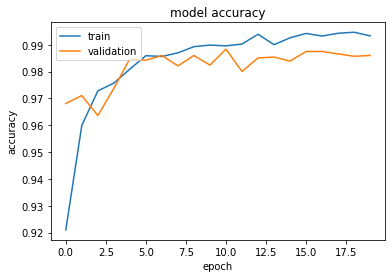

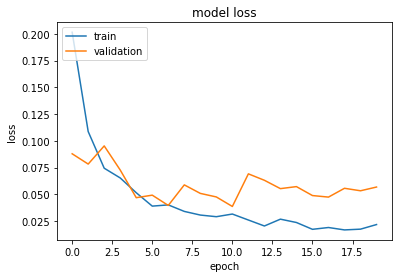

In [73]:
print(history.history.keys())

#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(folder_date + "/accuracy.png")
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(folder_date + "/loss.png")
plt.show()





Preguntas, cómo puedo gestionar datos que vienen de dos distribuciones distintas?



# This is a section to evaluate the model on te test data

In [74]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support


[0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


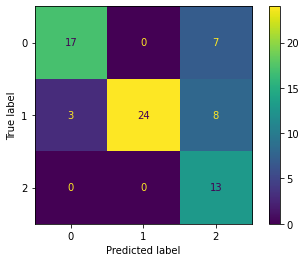

In [75]:
# Load the test images from the folder 'test_images'
predicted_labels= []
true_labels = []

directory = "test_set"

for filename in os.listdir(directory):

    # Load the image and add it to the list of test images
    f = os.path.join(directory, filename)
    imagen = tf.keras.preprocessing.image.load_img(f, target_size=(255,255))
    x = tf.keras.preprocessing.image.img_to_array(imagen)    
    x = np.expand_dims(x, axis=0)



    prediction = modelo.predict(x)
    
    predicted_class = np.argmax(prediction)

    #True labels are calculated based on name. It is a very weak way of doing it. Look for a better one or rename the files

    if 'aca' in filename:
        true_labels.append(0)
    elif 'scc' in filename or ' e ' in filename:
        true_labels.append(2)
    elif 'lungn' or ' N ' in filename:
        true_labels.append(1)
   
    

    predicted_labels.append(predicted_class)

print(predicted_labels)
print(true_labels)


cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
precision_recall_fscore_support(true_labels, predicted_labels)


disp.plot()
plt.show()



#Predice mal en las muestras de Henar. Veremos con el nuevo dataset, pero quizá haya que hacer un training con peso Opciones:

Undersample the larger distribution: randomly remove examples from the larger distribution until it matches the size of the smaller one.

Oversample the smaller distribution: randomly duplicate examples from the smaller distribution until it matches the size of the larger one.

Data augmentation: generate new examples from the smaller distribution using techniques like rotation, flipping, or zooming.

Use class weights: adjust the loss function of your CNN to assign higher weights to the smaller distribution so that it receives more emphasis during training.

Fine-tuning: you could use a pre-trained model to initialize the weights and only fine-tune the last few layers to fit the imbalanced data.

# Hacer una gridsearch

# Bayesian optimization